# Análise de alunos do integrado do IFRN
a base de dados consiste em dados socioeconômicos e as notas finais de português e matemática do 1º e 2º ano. Essas disciplinas foram selecionadas devido a certeza delas estarem presente em todos os cursos de integrado ofertados no IFRN

In [1]:
#import os pacotes utilizados
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

#ESCALONAMENTO DE DADOS
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import RobustScaler

#SELECIONANDO MELHOR MODELO
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_classification
from scipy.stats import randint as sp_randint
from sklearn.cross_validation import train_test_split

#Evaluating
import seaborn as sns; sns.set()

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score 
from sklearn.metrics import precision_score, recall_score 
from sklearn.metrics import f1_score

#EXPORTAR ARVORE
from sklearn.tree import export_graphviz
import os

#CURVA ROC
%matplotlib inline
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_predict 
from sklearn.metrics import roc_auc_score

#REDUÇÃO DE DIMENSIONALIDADE
from sklearn.decomposition import PCA

#exibindo todas as colunas
pd.set_option('display.max_columns', None)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
#definicao de funcoes que serao utilizadas

# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")
            
def plot_roc_curve(fpr, tpr, label=None):    
    plt.plot(fpr, tpr, linewidth=2, label=label)    
    plt.plot([0, 1], [0, 1], 'k--')    
    plt.axis([0, 1, 0, 1])   
    plt.xlabel('False Positive Rate')    
    plt.ylabel('True Positive Rate')

In [62]:
#importando base já tratada
dados = pd.read_json('dados/dados_flat_sem_social.json')
print(dados.id.nunique())
print(dados.shape)
dados.head(3)

7587
(7587, 16)


,LnguaPortuguesaeLiteraturaI90H,LnguaPortuguesaeLiteraturaII90H,MatemticaI120H,MatemticaII90H,ano_letivo__ano,ano_letivo__ano_matricula_periodo,cep,classe,descricao,descricao_historico,descricao_situacao_matricula_periodo,id,percentual_frequencia,pessoa_fisica__nascimento_data,pessoa_fisica__sexo,sigla
10000,72,41.0,68,0.0,2015,2015,59215-000,1,Matriculado,Técnico de Nível Médio em Administração,Dependência,464291724941,92.0,10/08/1999,M,NC
10001,73,68.0,70,0.0,2017,2015,59255-000,1,Matriculado,Técnico de Nível Médio em Administração,Dependência,573829066825,100.0,26/07/2000,F,NC
10002,66,NaN,60,NaN,2016,2016,59219-000,1,Matriculado,Técnico de Nível Médio em Administração,Dependência,503648996253,100.0,25/01/2001,M,NC


In [63]:
#removendo colunas que explodem a quantidade de atributos quando binarizados
del dados['id']

#dados que fazem a indicação se o aluno teve evasão
del dados['descricao']
del dados['descricao_situacao_matricula_periodo']

In [64]:
#transformando o dado em int
dados['cep'] = dados['cep'].str.replace('-', '')
dados['cep'] = dados['cep'].apply(pd.to_numeric, errors='coerce')

In [65]:
#transformando o dado em int
dados['pessoa_fisica__nascimento_data'] = dados['pessoa_fisica__nascimento_data'].str.replace('/','').apply(int)

In [66]:
#convertendo os NaN das notas em -1 para usar o RF 
dados['LnguaPortuguesaeLiteraturaI90H'].fillna(-1, inplace=True)
dados['MatemticaI120H'].fillna(-1, inplace=True)
dados['LnguaPortuguesaeLiteraturaII90H'].fillna(-1, inplace=True)
dados['MatemticaII90H'].fillna(-1, inplace=True)

In [70]:
#limpando os NaN devido ao RF
print(dados.shape)
df = dados.dropna()
dados = df
print(dados.shape)

(7587, 13)


In [71]:
#configura os dados de entrada e saída
y = dados.classe
X = dados

del X['classe']
X.shape

(7457, 12)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


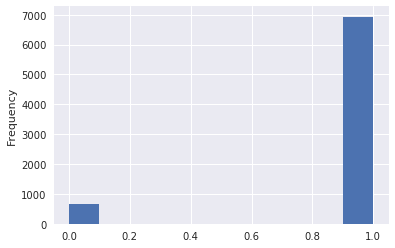

In [29]:
#visualizacao hist da classe
y.plot.hist()

In [72]:
#binazira os dados devido aos atributos categoricos 
dados_dummies = pd.get_dummies(X, drop_first=False)
dados_dummies.shape

(7457, 65)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


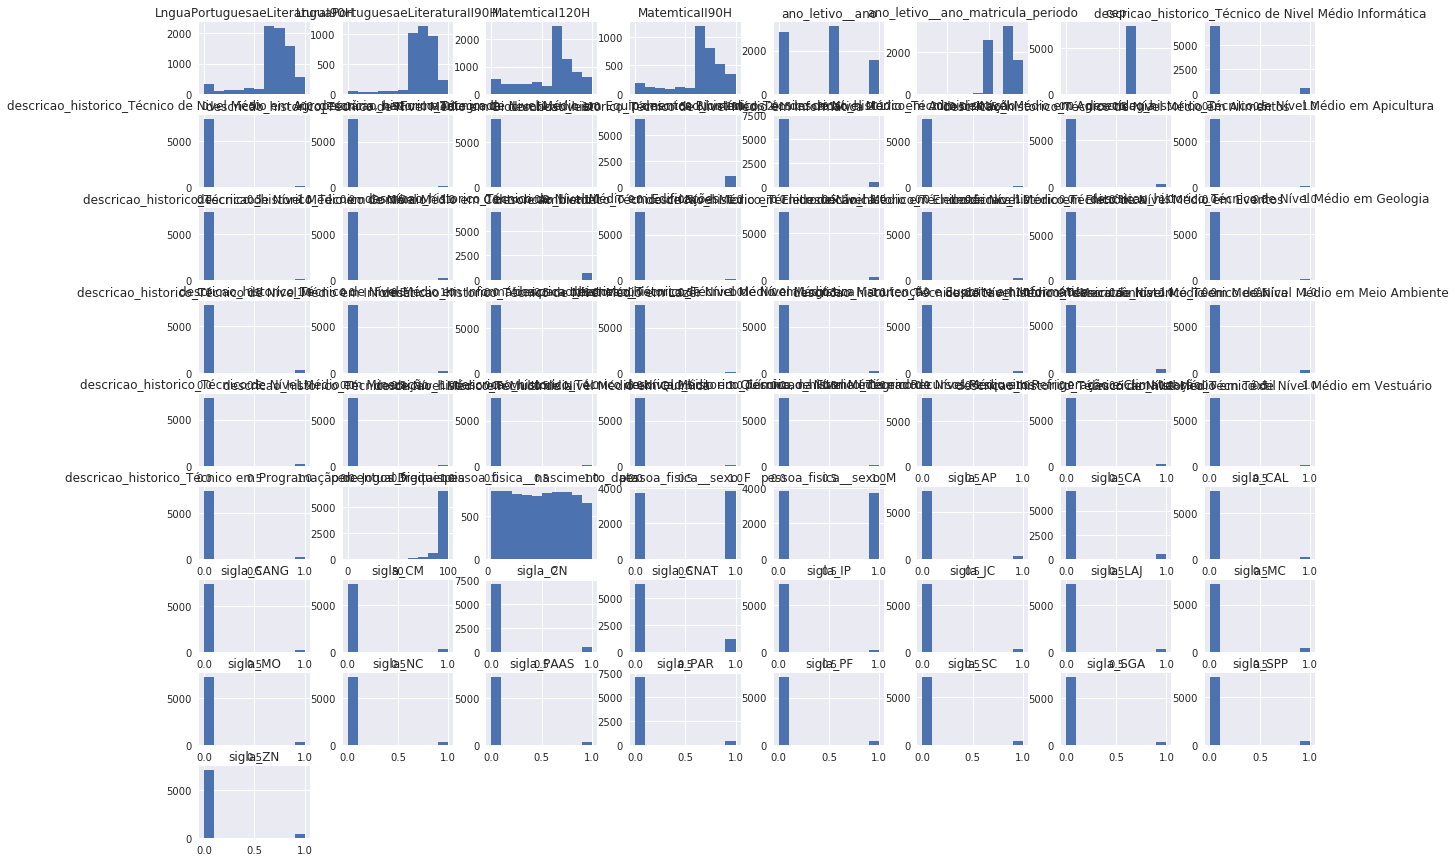

In [18]:
dados_dummies.hist(figsize=(20, 15))
plt.show()

In [73]:
#remove atributos inconistentes
dados_clean = dados_dummies.replace([np.inf, -np.inf], np.nan)
dados_clean = dados_clean.dropna(axis=1, how='all')
dados_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7457 entries, 10000 to 9997
Data columns (total 65 columns):
LnguaPortuguesaeLiteraturaI90H                                                       7457 non-null int64
LnguaPortuguesaeLiteraturaII90H                                                      7457 non-null float64
MatemticaI120H                                                                       7457 non-null int64
MatemticaII90H                                                                       7457 non-null float64
ano_letivo__ano                                                                      7457 non-null int64
ano_letivo__ano_matricula_periodo                                                    7457 non-null int64
cep                                                                                  7457 non-null float64
percentual_frequencia                                                                7457 non-null float64
pessoa_fisica__nascimento_data           

In [74]:
#SELECIONANDO MELHOR MODEL RF

#cria a randomforest 
forest_clf = RandomForestClassifier(oob_score=True, n_jobs=-1) 

param_grid_forest = {'max_depth': [3, 5, None],
              'max_features': ['auto', 'sqrt', 'log2'],
              'n_estimators': [10, 30, 60, 100, 200, 500, 1000],
              'criterion': ["gini", "entropy"]}

#dividir os dados para treino e teste. default é 25% p teste
Xtrain, Xtest, ytrain, ytest = train_test_split(dados_clean, y, random_state=0)

#seleciona o melhor modelo de acordo com os parâmetros
grid_search_forest = GridSearchCV(estimator=forest_clf, param_grid=param_grid_forest)
grid_search_forest.fit(Xtrain, ytrain)
print(grid_search_forest.best_params_)
print(grid_search_forest.best_estimator_)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:439: UserWarning: Some inputs 

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:439: UserWarning: Some inputs 

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:439: UserWarning: Some inputs 

{'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'n_estimators': 60}
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=60, n_jobs=-1, oob_score=True, random_state=None,
            verbose=0, warm_start=False)


In [75]:
#mostra os 5 melhores modelos
report(grid_search_forest.cv_results_, 5)

Model with rank: 1
Mean validation score: 0.954 (std: 0.004)
Parameters: {'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'n_estimators': 60}

Model with rank: 2
Mean validation score: 0.954 (std: 0.003)
Parameters: {'criterion': 'entropy', 'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 10}

Model with rank: 3
Mean validation score: 0.954 (std: 0.005)
Parameters: {'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'n_estimators': 100}

Model with rank: 3
Mean validation score: 0.954 (std: 0.003)
Parameters: {'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 60}

Model with rank: 5
Mean validation score: 0.953 (std: 0.004)
Parameters: {'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'n_estimators': 500}



In [76]:
#seleciona o melhor modelo
model_forest = grid_search_forest.best_estimator_
ypred_forest = model_forest.predict(Xtest)

0.965596330275
0.985948477752
0.965596330275
0.985948477752
0.975666280417
157


/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


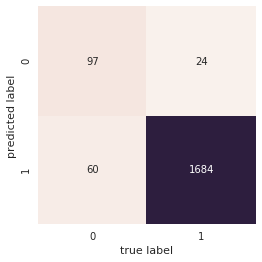

In [77]:
#Evaluating
mat = confusion_matrix(ytest, ypred_forest)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

#evaluating
print(precision_score(ytest, ypred_forest))
print(recall_score(ytest, ypred_forest))

#evaluating
print(precision_score(ytest, ypred_forest))
print(recall_score(ytest, ypred_forest))
print(f1_score(ytest, ypred_forest))

#qnt de evadidos 
print(sum(ytest==0))

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


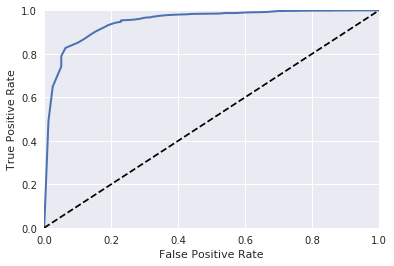

0.947385104193


In [78]:
#CURVA ROC

y_probas_forest = cross_val_predict(model_forest, Xtest, ytest, cv=3, method="predict_proba") 

y_scores_forest = y_probas_forest[:, 1]   # score = proba of positive class 
fpr_forest, tpr_forest, thresholds_forest = roc_curve(ytest, y_scores_forest)

plot_roc_curve(fpr_forest, tpr_forest) 
plt.show()
print(roc_auc_score(ytest, y_scores_forest))

Feature ranking:
1. feature 0 [LnguaPortuguesaeLiteraturaI90H] (0.192460)
2. feature 2 [MatemticaI120H] (0.139080)
3. feature 7 [percentual_frequencia] (0.099464)
4. feature 5 [ano_letivo__ano_matricula_periodo] (0.091417)
5. feature 1 [LnguaPortuguesaeLiteraturaII90H] (0.077216)
6. feature 8 [pessoa_fisica__nascimento_data] (0.060976)
7. feature 6 [cep] (0.059452)
8. feature 3 [MatemticaII90H] (0.046188)
9. feature 4 [ano_letivo__ano] (0.042260)
10. feature 55 [sigla_MC] (0.012192)
11. feature 43 [pessoa_fisica__sexo_F] (0.010705)
12. feature 44 [pessoa_fisica__sexo_M] (0.009231)
13. feature 51 [sigla_CNAT] (0.007640)
14. feature 13 [descricao_historico_Técnico de Nivel Médio em Informática] (0.007396)
15. feature 46 [sigla_CA] (0.006323)
16. feature 38 [descricao_historico_Técnico de Nível Médio em Recursos Pesqueiros] (0.006260)
17. feature 42 [descricao_historico_Técnico em Programação de Jogos Digitais] (0.005953)
18. feature 14 [descricao_historico_Técnico de Nível Médio em Admin

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


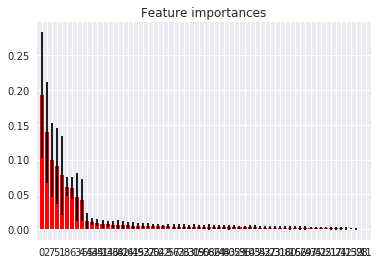

In [79]:
#exibe os atributos mais importantes

importances = model_forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in model_forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(Xtest.shape[1]):
    print("%d. feature %d [%s] (%f)" % (f + 1, indices[f], dados_clean.columns[indices[f]],importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(Xtest.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(Xtest.shape[1]), indices)
plt.xlim([-1, Xtest.shape[1]])
plt.show()

In [80]:
#DECISION TREE
tree_clf = DecisionTreeClassifier() 

param_grid_tree = {"criterion": ["gini", "entropy"],
              "min_samples_split": [2, 10, 20],
              "max_depth": [None, 2, 3, 5, 10],
              "min_samples_leaf": [1, 5, 10],
              "max_leaf_nodes": [None, 5, 10, 20],
              }

#seleciona o melhor modelo de acordo com os parâmetros
grid_search_tree = GridSearchCV(estimator=tree_clf, param_grid=param_grid_tree)
grid_search_tree.fit(Xtrain, ytrain)
print(grid_search_tree.best_params_)
print(grid_search_tree.best_estimator_)

{'criterion': 'entropy', 'max_depth': 5, 'max_leaf_nodes': 20, 'min_samples_leaf': 10, 'min_samples_split': 2}
DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=5,
            max_features=None, max_leaf_nodes=20, min_impurity_split=1e-07,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')


In [81]:
#seleciona o melhor modelo e exibe os 5 melhores
report(grid_search_tree.cv_results_, 5)

model_tree = grid_search_tree.best_estimator_
ypred_tree = model_tree.predict(Xtest)

Model with rank: 1
Mean validation score: 0.950 (std: 0.004)
Parameters: {'criterion': 'entropy', 'max_depth': 5, 'max_leaf_nodes': 20, 'min_samples_leaf': 10, 'min_samples_split': 2}

Model with rank: 1
Mean validation score: 0.950 (std: 0.004)
Parameters: {'criterion': 'entropy', 'max_depth': 5, 'max_leaf_nodes': 20, 'min_samples_leaf': 10, 'min_samples_split': 10}

Model with rank: 1
Mean validation score: 0.950 (std: 0.004)
Parameters: {'criterion': 'entropy', 'max_depth': 5, 'max_leaf_nodes': 20, 'min_samples_leaf': 10, 'min_samples_split': 20}

Model with rank: 4
Mean validation score: 0.950 (std: 0.004)
Parameters: {'criterion': 'entropy', 'max_depth': 5, 'max_leaf_nodes': 20, 'min_samples_leaf': 5, 'min_samples_split': 20}

Model with rank: 5
Mean validation score: 0.949 (std: 0.004)
Parameters: {'criterion': 'entropy', 'max_depth': 5, 'max_leaf_nodes': 20, 'min_samples_leaf': 5, 'min_samples_split': 2}

Model with rank: 5
Mean validation score: 0.949 (std: 0.004)
Parameters: {

0.946380697051
0.969626168224
0.971896955504
0.970760233918


/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


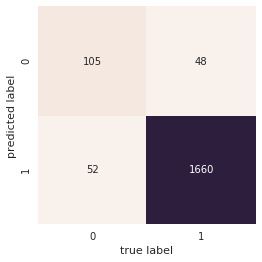

In [82]:
#porcentagem de predicao correta
n_correct = sum(ypred_tree == ytest)    
print(n_correct / len(ypred_tree)) 

#evaluating
mat = confusion_matrix(ytest, ypred_tree)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

#evaluating
print(precision_score(ytest, ypred_tree))
print(recall_score(ytest, ypred_tree))
print(f1_score(ytest, ypred_tree))

In [83]:
#gera a arvore de decisao
export_graphviz(model_tree,
                feature_names=dados_clean.columns,
                filled=True,
                rounded=True, 
                out_file='tree.dot')

os.system('dot -Tpng tree.dot -o tree.png')

0

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


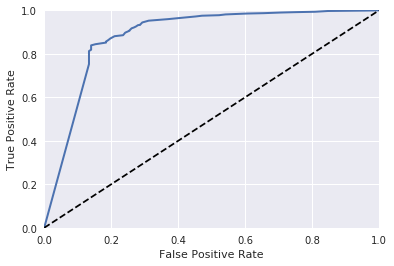

0.885490162443


In [84]:
y_probas_tree = cross_val_predict(model_tree, Xtest, ytest, cv=3, method="predict_proba") 

y_scores_tree = y_probas_tree[:, 1]   # score = proba of positive class 
fpr_tree, tpr_tree, thresholds_tree = roc_curve(ytest, y_scores_tree)

plot_roc_curve(fpr_tree, tpr_tree) 
plt.show()
print(roc_auc_score(ytest, y_scores_tree))

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/legend.py:326: UserWarning: Unrecognized location "bottom right". Falling back on "best"; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center

  six.iterkeys(self.codes))))
/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


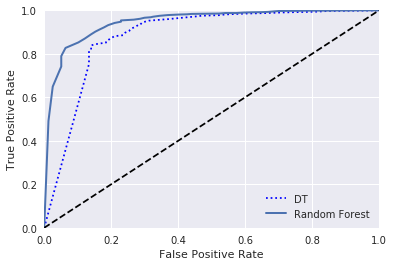

In [85]:
#PLOTAR DUAS CURVAS ROC (DT e RF)
plt.plot(fpr_tree, tpr_tree, "b:", label="DT") 
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest") 
plt.legend(loc="bottom right") 
plt.show()

[ 0.98025088  0.01974912]
(7457, 2)


/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


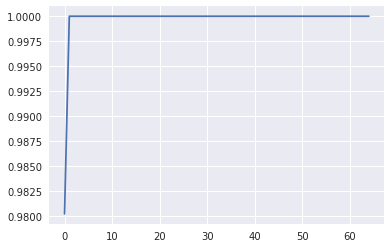

In [87]:
#REDUÇÃO DE DIMENSIONALIDADE

#pca = PCA(n_components=0.95) 
pca = PCA(n_components=2) 
X_reduced = pca.fit_transform(dados_clean) 

print(pca.explained_variance_ratio_) 
print(X_reduced.shape)

pca = PCA() 
pca.fit(dados_clean) 
cumsum = np.cumsum(pca.explained_variance_ratio_) 
d = np.argmax(cumsum >= 0.95) + 1
plt.plot(cumsum)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


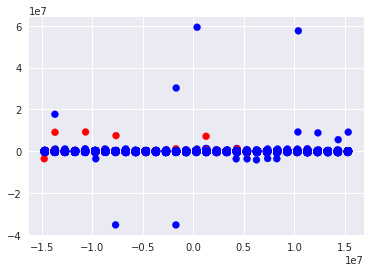

In [88]:
colors = ['red','blue']
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, cmap=matplotlib.colors.ListedColormap(colors))

In [89]:
#cria a randomforest  
forest_pca = RandomForestClassifier() 

param_grid_pca = {'max_depth': [3, 5, None],
              'max_features': ['auto', 'sqrt', 'log2'],
              'n_estimators': [10, 30, 60, 100, 200, 500, 1000],              
              'criterion': ["gini", "entropy"]}


#dividir os dados para treino e teste. default é 25% p teste
Xtrain_pca, Xtest_pca, ytrain_pca, ytest_pca = train_test_split(X_reduced, y, random_state=0)

#seleciona o melhor modelo de acordo com os parâmetros
grid_search_pca = GridSearchCV(estimator=forest_pca, param_grid=param_grid_pca, cv = 5)
grid_search_pca.fit(Xtrain_pca, ytrain_pca)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_depth': [3, 5, None], 'max_features': ['auto', 'sqrt', 'log2'], 'n_estimators': [10, 30, 60, 100, 200, 500, 1000], 'criterion': ['gini', 'entropy']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [90]:
print(grid_search_pca.best_params_)
print(grid_search_pca.best_estimator_)

#exibir melhor modelo
report(grid_search_pca.cv_results_, 5)

#seleciona o melhor modelo
model_pca = grid_search_pca.best_estimator_
ypred_pca = model_pca.predict(Xtest_pca)

{'criterion': 'gini', 'max_depth': 5, 'max_features': 'auto', 'n_estimators': 30}
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=30, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
Model with rank: 1
Mean validation score: 0.914 (std: 0.001)
Parameters: {'criterion': 'gini', 'max_depth': 5, 'max_features': 'auto', 'n_estimators': 30}

Model with rank: 1
Mean validation score: 0.914 (std: 0.001)
Parameters: {'criterion': 'gini', 'max_depth': 5, 'max_features': 'auto', 'n_estimators': 60}

Model with rank: 1
Mean validation score: 0.914 (std: 0.001)
Parameters: {'criterion': 'entropy', 'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 10}

Model with rank: 4
Mean validation score: 0.914 (std: 0.001)
Parame

0.915772532189
0.999414519906
0.915772532189
0.999414519906
0.955767077268


/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


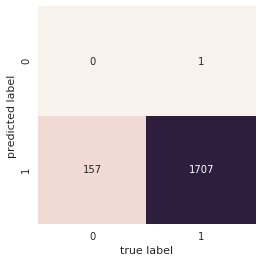

In [91]:
#Evaluating
mat = confusion_matrix(ytest_pca, ypred_pca)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

#evaluating
print(precision_score(ytest_pca, ypred_pca))
print(recall_score(ytest_pca, ypred_pca))

#evaluating
print(precision_score(ytest_pca, ypred_pca))
print(recall_score(ytest_pca, ypred_pca))
print(f1_score(ytest_pca, ypred_pca))

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


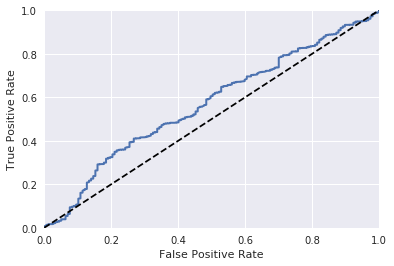

0.567425304673


In [92]:
#CURVA ROC
y_probas_pca = cross_val_predict(model_pca, Xtest_pca, ytest_pca, cv=3, method="predict_proba") 

y_scores_pca = y_probas_pca[:, 1]   # score = proba of positive class 
fpr_pca, tpr_pca, thresholds_pca = roc_curve(ytest_pca, y_scores_pca)

plot_roc_curve(fpr_pca, tpr_pca) 
plt.show()
print(roc_auc_score(ytest_pca, y_scores_pca))


{'criterion': 'gini', 'max_depth': 5, 'max_leaf_nodes': 20, 'min_samples_leaf': 5, 'min_samples_split': 20}
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=20, min_impurity_split=1e-07,
            min_samples_leaf=5, min_samples_split=20,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
Model with rank: 1
Mean validation score: 0.928 (std: 0.002)
Parameters: {'criterion': 'gini', 'max_depth': 5, 'max_leaf_nodes': 20, 'min_samples_leaf': 5, 'min_samples_split': 20}

Model with rank: 2
Mean validation score: 0.927 (std: 0.004)
Parameters: {'criterion': 'gini', 'max_depth': 10, 'max_leaf_nodes': 20, 'min_samples_leaf': 5, 'min_samples_split': 20}

Model with rank: 3
Mean validation score: 0.927 (std: 0.004)
Parameters: {'criterion': 'gini', 'max_depth': None, 'max_leaf_nodes': 20, 'min_samples_leaf': 5, 'min_samples_split': 20}

Model with rank: 4
Mean validation

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


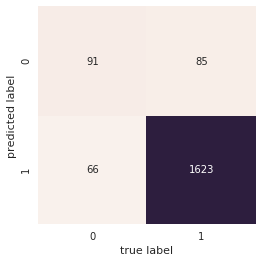

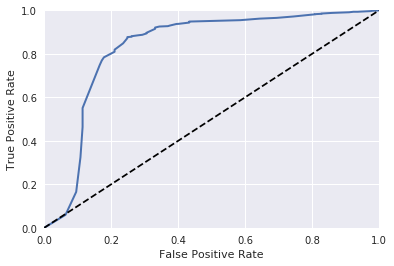

0.830924909381


In [95]:
#UTILIZANDO APENAS AS NOTAS
dados_reduzido = dados_clean[['LnguaPortuguesaeLiteraturaI90H', 'MatemticaI120H', 
                              'LnguaPortuguesaeLiteraturaII90H', 'MatemticaII90H']]


#dividir os dados para treino e teste. default é 25% p teste
Xtrain_red, Xtest_red, ytrain_red, ytest_red = train_test_split(dados_reduzido, y, random_state=0)

tree_clf = DecisionTreeClassifier() 

param_grid_tree_red = {"criterion": ["gini", "entropy"],
              "min_samples_split": [2, 10, 20],
              "max_depth": [None, 2, 3, 5, 10],
              "min_samples_leaf": [1, 5, 10],
              "max_leaf_nodes": [None, 5, 10, 20],
              }

#seleciona o melhor modelo de acordo com os parâmetros
grid_search_red = GridSearchCV(estimator=tree_clf, param_grid=param_grid_tree_red)
grid_search_red.fit(Xtrain_red, ytrain_red)
print(grid_search_red.best_params_)
print(grid_search_red.best_estimator_)

#mostra os melhores 5 modelos
report(grid_search_red.cv_results_, 5)

#realiza predicao
model_red = grid_search_red.best_estimator_
ypred_red = model_red.predict(Xtest_red)

#avalia modelo
n_correct = sum(ypred_red == ytest_red)    
print(n_correct / len(ypred_red)) 

#evaluating
mat = confusion_matrix(ytest_red, ypred_red)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

#evaluating
print(precision_score(ytest_red, ypred_red))
print(recall_score(ytest_red, ypred_red))
print(f1_score(ytest_red, ypred_red))

#curva ROC
y_probas_tree_red = cross_val_predict(model_red, Xtest_red, ytest_red, cv=3, method="predict_proba") 

y_scores_tree_red = y_probas_tree_red[:, 1]   # score = proba of positive class 
fpr_tree_red, tpr_tree_red, thresholds_tree_red = roc_curve(ytest_red, y_scores_tree_red)

fig = plt.figure()

plot_roc_curve(fpr_tree_red, tpr_tree_red) 
plt.show()
print(roc_auc_score(ytest_red, y_scores_tree_red))

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/legend.py:326: UserWarning: Unrecognized location "bottom right". Falling back on "best"; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center

  six.iterkeys(self.codes))))
/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


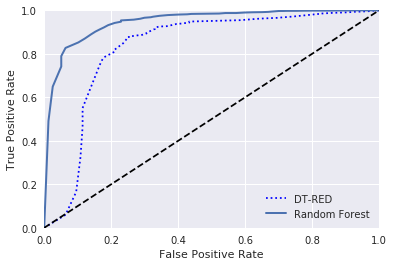

In [96]:
#PLOTAR DUAS CURVAS ROC (DT e RF)
plt.plot(fpr_tree_red, tpr_tree_red, "b:", label="DT-RED") 
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest") 
plt.legend(loc="bottom right") 
plt.show()

{'criterion': 'entropy', 'max_depth': 2, 'max_leaf_nodes': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')
Model with rank: 1
Mean validation score: 0.928 (std: 0.003)
Parameters: {'criterion': 'entropy', 'max_depth': 2, 'max_leaf_nodes': None, 'min_samples_leaf': 1, 'min_samples_split': 2}

Model with rank: 1
Mean validation score: 0.928 (std: 0.003)
Parameters: {'criterion': 'entropy', 'max_depth': 2, 'max_leaf_nodes': None, 'min_samples_leaf': 1, 'min_samples_split': 10}

Model with rank: 1
Mean validation score: 0.928 (std: 0.003)
Parameters: {'criterion': 'entropy', 'max_depth': 2, 'max_leaf_nodes': None, 'min_samples_leaf': 1, 'min_samples_split': 20}

Model with rank:

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


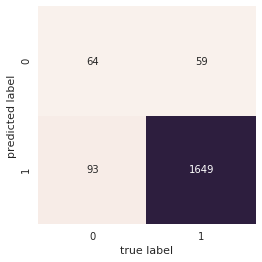

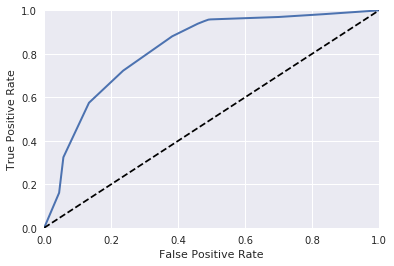

0.821575873745


In [97]:
#UTILIZANDO AS MÉDIAS DE CADA ANO

nota_1 = dados_clean[['LnguaPortuguesaeLiteraturaI90H', 'MatemticaI120H']].mean(axis=1)
nota_2 = dados_clean[['LnguaPortuguesaeLiteraturaII90H', 'MatemticaII90H']].mean(axis=1)

dados_reduzido = pd.DataFrame()
dados_reduzido['1_ano'] = nota_1
dados_reduzido['2_ano'] = nota_2


#dividir os dados para treino e teste. default é 25% p teste
Xtrain_red, Xtest_red, ytrain_red, ytest_red = train_test_split(dados_reduzido, y, random_state=0)

tree_clf = DecisionTreeClassifier() 

param_grid_tree_red = {"criterion": ["gini", "entropy"],
              "min_samples_split": [2, 10, 20],
              "max_depth": [None, 2, 3, 5, 10],
              "min_samples_leaf": [1, 5, 10],
              "max_leaf_nodes": [None, 5, 10, 20],
              }

#seleciona o melhor modelo de acordo com os parâmetros
grid_search_red = GridSearchCV(estimator=tree_clf, param_grid=param_grid_tree_red)
grid_search_red.fit(Xtrain_red, ytrain_red)
print(grid_search_red.best_params_)
print(grid_search_red.best_estimator_)

#mostra os melhores 5 modelos
report(grid_search_red.cv_results_, 5)

#realiza predicao
model_red = grid_search_red.best_estimator_
ypred_red = model_red.predict(Xtest_red)

#avalia modelo
n_correct = sum(ypred_red == ytest_red)    
print(n_correct / len(ypred_red)) 

#evaluating
mat = confusion_matrix(ytest_red, ypred_red)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

#evaluating
print(precision_score(ytest_red, ypred_red))
print(recall_score(ytest_red, ypred_red))
print(f1_score(ytest_red, ypred_red))

#curva ROC
y_probas_tree_red = cross_val_predict(model_red, Xtest_red, ytest_red, cv=3, method="predict_proba") 

y_scores_tree_red = y_probas_tree_red[:, 1]   # score = proba of positive class 
fpr_tree_red, tpr_tree_red, thresholds_tree_red = roc_curve(ytest_red, y_scores_tree_red)

fig = plt.figure()

plot_roc_curve(fpr_tree_red, tpr_tree_red) 
plt.show()
print(roc_auc_score(ytest_red, y_scores_tree_red))

In [101]:
#SELECIONANDO OS MELHORES ATRIBUTOS PARA TREINAMENTO
#CRITERIO UTILIZADO 80% DA IMPORTANCIA
print("Feature ranking:")

imp_cum = 0

for f in range(Xtest.shape[1]):
    print("%d. feature %d [%s] (%f)" % (f + 1, indices[f], dados_clean.columns[indices[f]],importances[indices[f]]))
    imp_cum = imp_cum + importances[indices[f]]
    print(imp_cum)

Feature ranking:
1. feature 0 [LnguaPortuguesaeLiteraturaI90H] (0.192460)
0.192460281604
2. feature 2 [MatemticaI120H] (0.139080)
0.331539881446
3. feature 7 [percentual_frequencia] (0.099464)
0.431003711942
4. feature 5 [ano_letivo__ano_matricula_periodo] (0.091417)
0.522420849124
5. feature 1 [LnguaPortuguesaeLiteraturaII90H] (0.077216)
0.599637253118
6. feature 8 [pessoa_fisica__nascimento_data] (0.060976)
0.660613540007
7. feature 6 [cep] (0.059452)
0.720065071832
8. feature 3 [MatemticaII90H] (0.046188)
0.766252636491
9. feature 4 [ano_letivo__ano] (0.042260)
0.808513091871
10. feature 55 [sigla_MC] (0.012192)
0.820704882602
11. feature 43 [pessoa_fisica__sexo_F] (0.010705)
0.831410185368
12. feature 44 [pessoa_fisica__sexo_M] (0.009231)
0.8406410891
13. feature 51 [sigla_CNAT] (0.007640)
0.848281333575
14. feature 13 [descricao_historico_Técnico de Nivel Médio em Informática] (0.007396)
0.855677465545
15. feature 46 [sigla_CA] (0.006323)
0.862000087561
16. feature 38 [descricao_h

{'criterion': 'entropy', 'max_depth': 3, 'max_leaf_nodes': 20, 'min_samples_leaf': 1, 'min_samples_split': 2}
DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=3,
            max_features=None, max_leaf_nodes=20, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
Model with rank: 1
Mean validation score: 0.947 (std: 0.007)
Parameters: {'criterion': 'entropy', 'max_depth': 3, 'max_leaf_nodes': 20, 'min_samples_leaf': 1, 'min_samples_split': 2}

Model with rank: 1
Mean validation score: 0.947 (std: 0.007)
Parameters: {'criterion': 'entropy', 'max_depth': 3, 'max_leaf_nodes': 20, 'min_samples_leaf': 1, 'min_samples_split': 10}

Model with rank: 1
Mean validation score: 0.947 (std: 0.007)
Parameters: {'criterion': 'entropy', 'max_depth': 3, 'max_leaf_nodes': 20, 'min_samples_leaf': 1, 'min_samples_split': 20}

Model with rank: 4
Mean va

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


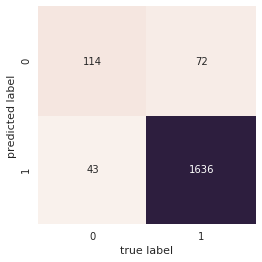

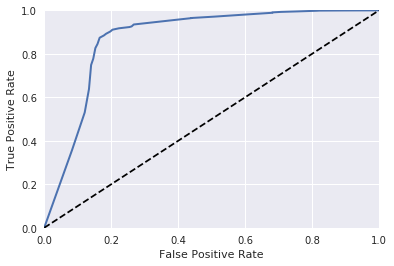

0.874364176077


In [102]:
dados_reduzido = dados_clean[['LnguaPortuguesaeLiteraturaI90H', 'MatemticaI120H', 
                              'LnguaPortuguesaeLiteraturaII90H', 'MatemticaII90H', 
                              'percentual_frequencia', 'ano_letivo__ano_matricula_periodo', 
                              'pessoa_fisica__nascimento_data', 'cep', 
                              'ano_letivo__ano']]


#dividir os dados para treino e teste. default é 25% p teste
Xtrain_red, Xtest_red, ytrain_red, ytest_red = train_test_split(dados_reduzido, y, random_state=0)

tree_clf = DecisionTreeClassifier() 

param_grid_tree_red = {"criterion": ["gini", "entropy"],
              "min_samples_split": [2, 10, 20],
              "max_depth": [None, 2, 3, 5, 10],
              "min_samples_leaf": [1, 5, 10],
              "max_leaf_nodes": [None, 5, 10, 20],
              }

#seleciona o melhor modelo de acordo com os parâmetros
grid_search_red = GridSearchCV(estimator=tree_clf, param_grid=param_grid_tree_red)
grid_search_red.fit(Xtrain_red, ytrain_red)
print(grid_search_red.best_params_)
print(grid_search_red.best_estimator_)

#mostra os melhores 5 modelos
report(grid_search_red.cv_results_, 5)

#realiza predicao
model_red = grid_search_red.best_estimator_
ypred_red = model_red.predict(Xtest_red)

#avalia modelo
n_correct = sum(ypred_red == ytest_red)    
print(n_correct / len(ypred_red)) 

#evaluating
mat = confusion_matrix(ytest_red, ypred_red)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

#evaluating
print(precision_score(ytest_red, ypred_red))
print(recall_score(ytest_red, ypred_red))
print(f1_score(ytest_red, ypred_red))

#curva ROC
y_probas_tree_red = cross_val_predict(model_red, Xtest_red, ytest_red, cv=3, method="predict_proba") 

y_scores_tree_red = y_probas_tree_red[:, 1]   # score = proba of positive class 
fpr_tree_red, tpr_tree_red, thresholds_tree_red = roc_curve(ytest_red, y_scores_tree_red)

fig = plt.figure()

plot_roc_curve(fpr_tree_red, tpr_tree_red) 
plt.show()
print(roc_auc_score(ytest_red, y_scores_tree_red))
